Epoch 1/50, Train Loss: 4574.0023, Val Loss: 3450.9224, R^2: -3.2312
Epoch 2/50, Train Loss: 2031.9236, Val Loss: 3434.9626, R^2: -3.2116
Epoch 3/50, Train Loss: 4519.5403, Val Loss: 3413.8218, R^2: -3.1857
Epoch 4/50, Train Loss: 2989.0405, Val Loss: 3386.0684, R^2: -3.1517
Epoch 5/50, Train Loss: 6510.9465, Val Loss: 3352.0356, R^2: -3.1099
Epoch 6/50, Train Loss: 2280.7445, Val Loss: 3310.1084, R^2: -3.0585
Epoch 7/50, Train Loss: 1941.0036, Val Loss: 3258.7039, R^2: -2.9955
Epoch 8/50, Train Loss: 2206.7813, Val Loss: 3193.4961, R^2: -2.9156
Epoch 9/50, Train Loss: 6204.7036, Val Loss: 3111.9543, R^2: -2.8156
Epoch 10/50, Train Loss: 1662.2125, Val Loss: 3015.6914, R^2: -2.6976
Epoch 11/50, Train Loss: 1791.8079, Val Loss: 2902.8369, R^2: -2.5592
Epoch 12/50, Train Loss: 1893.9819, Val Loss: 2764.5046, R^2: -2.3896
Epoch 13/50, Train Loss: 2951.2007, Val Loss: 2596.0730, R^2: -2.1831
Epoch 14/50, Train Loss: 1480.0830, Val Loss: 2398.3291, R^2: -1.9406
Epoch 15/50, Train Loss: 3121

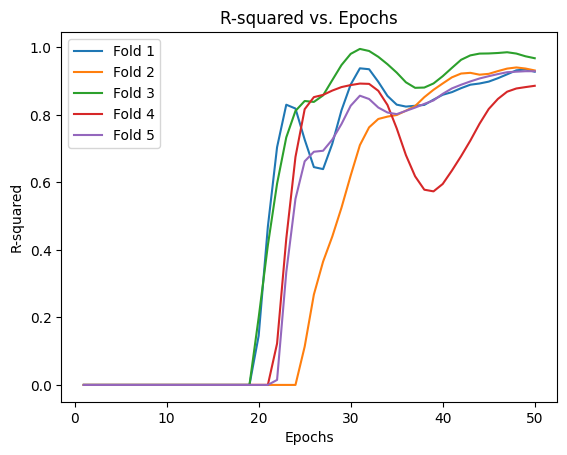

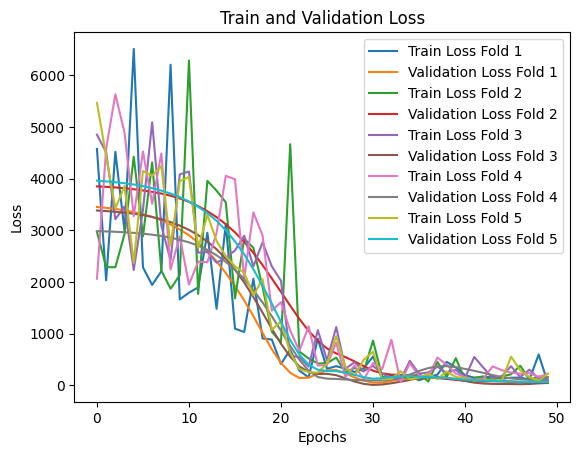

In [32]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data preparation
folder_path = 'data/csv-clean-renamed'
wavenumbers = []
data = []
labels = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(folder_path, filename)
        spectrum = pd.read_csv(filepath, delimiter=',', header=None)
        wavenumbers.append(spectrum[0].values)
        data.append(spectrum[1].values)
        concentration = float(filename.split('_')[0].replace('conc-', ''))
        labels.append(concentration)

wavenumbers = np.array(wavenumbers)
data = np.array(data)
labels = np.array(labels)

max_wavenumber = 1800
index_max_1500 = np.where(wavenumbers[0] <= max_wavenumber)[0][-1]
wavenumbers_trimmed = wavenumbers[0][:index_max_1500 + 1]
data_trimmed = data[:, :index_max_1500 + 1]
data_normalized = np.array([spectrum / np.sum(spectrum) for spectrum in data_trimmed])

# Standard scaling
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_normalized)

X = data_normalized
y = labels

# Custom dataset class
class SpectraDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Custom neural network model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training function
def train_model_with_tracking(model, criterion, optimizer, train_loader, val_loader, num_epochs=50):
    model.train()
    train_losses = []
    val_losses = []
    r2_scores = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        predictions, true_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predictions.append(outputs.numpy())
                true_labels.append(labels.numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        predictions = np.vstack(predictions)
        true_labels = np.vstack(true_labels)
        r2 = r2_score(true_labels, predictions)
        r2_scores.append(r2)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R^2: {r2:.4f}")

    return train_losses, val_losses, r2_scores

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
            true_labels.append(labels.numpy())
    return np.vstack(predictions), np.vstack(true_labels)

# Cross-validation with tracking
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
mse_scores, mae_scores, r2_scores = [], [], []
all_train_losses, all_val_losses, all_r2_scores = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    train_dataset = SpectraDataset(X_train, y_train)
    val_dataset = SpectraDataset(X_val, y_val)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = Net(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, r2_tracking = train_model_with_tracking(model, criterion, optimizer, train_loader, val_loader, num_epochs=50)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_r2_scores.append(r2_tracking)

    predictions, true_labels = evaluate_model(model, val_loader)

    mse = mean_squared_error(true_labels, predictions)
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    # Plot R-squared tracking for this fold
    r2_tracking_clipped = np.clip(r2_tracking, 0, None)  # Ensure R-squared values are non-negative
    plt.plot(range(1, 51), r2_tracking_clipped, label=f'Fold {len(mse_scores)}')

print(f"Cross-Validated MSE: {np.mean(mse_scores)} ± {np.std(mse_scores)}")
print(f"Cross-Validated MAE: {np.mean(mae_scores)} ± {np.std(mae_scores)}")
print(f"Cross-Validated R^2: {np.mean(r2_scores)} ± {np.std(r2_scores)}")

# Plot R-squared tracking
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.title('R-squared vs. Epochs')
plt.legend()
plt.show()

# Plot Train and Validation Loss
for i in range(len(all_train_losses)):
    plt.plot(all_train_losses[i], label=f'Train Loss Fold {i+1}')
    plt.plot(all_val_losses[i], label=f'Validation Loss Fold {i+1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


In [33]:
# Final evaluation on a separate test file
model.eval()
predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
r2 = r2_score(y_test, predictions)
print(f"R^2 on test set: {r2}")

# Dictionary containing true values for the unknown samples
true_values = {
    'test-file-20.dpt': 20.0  # Replace with actual values
}

# Prediction for an unknown sample
def predict_concentration_for_unknown_samples(unknown_sample_filename):
    print(f'File name: {unknown_sample_filename}')
    unknown_sample_filepath = os.path.join('C:\\Users\\baubl\\OneDrive\\Stalinis kompiuteris\\Nuova cartella\\test', unknown_sample_filename)
    unknown_spectrum = pd.read_csv(unknown_sample_filepath, delimiter=',', header=None)
    index_max_1800 = np.where(unknown_spectrum[0] <= max_wavenumber)[0][-1]
    data_trimmed_unknown = unknown_spectrum[1].values[:index_max_1800 + 1]
    normalized_unknown_spectrum = data_trimmed_unknown / np.sum(data_trimmed_unknown)
    normalized_unknown_spectrum = scaler.transform([normalized_unknown_spectrum])  # Apply same scaling
    normalized_unknown_spectrum = torch.tensor(normalized_unknown_spectrum, dtype=torch.float32)

    predicted_percentage = model(normalized_unknown_spectrum).item()
    print(f'Predicted Percentage For Green Pigment: {predicted_percentage}')
    
    # Calculate MSE and MAE for the prediction
    true_value = true_values[unknown_sample_filename]
    mse_value = mean_squared_error([true_value], [predicted_percentage])
    mae_value = mean_absolute_error([true_value], [predicted_percentage])
    print(f'MSE for {unknown_sample_filename}: {mse_value}')
    print(f'MAE for {unknown_sample_filename}: {mae_value}')

# Predict and print MSE and MAE values for each file
predict_concentration_for_unknown_samples('test-file-20.dpt')

R^2 on test set: 0.9705799830287786
File name: test-file-20.dpt
Predicted Percentage For Green Pigment: 20.168943405151367
MSE for test-file-20.dpt: 0.028541874144139
MAE for test-file-20.dpt: 0.1689434051513672
